In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor as greg
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler as sdscale





## Data Preparation and Cleaning

Reading in the data

In [30]:
train = pd.read_csv(r"C:\Users\jmoore42\Downloads\train.csv", header=0)
test = pd.read_csv(r"C:\Users\jmoore42\Downloads\test.csv", header=0)

Here I use cross-tabs to examine why values are missing. For example, if those who have 0 in # of cars in garage also don't have a rating on garage quality, we can conclude this is a major reason why they are missing.

In [3]:
print(train.Utilities.unique())
print(pd.crosstab(train.Fireplaces, train.FireplaceQu))
#we want to replace Fireplace quality with either 0 (there is no fireplace) or the mean(fireplace quality
#is a proxy for house quality)

print(pd.crosstab(train.GarageCars, train.GarageCond))
train.GarageCars.describe() #min is 0, but 0 not included in cross-tab.
##For the garage variables, it is missing if there is no garage.

#print(pd.crosstab(train.BsmtFinSF2, train.BsmtExposure))

#print(train.LotFrontage.describe())
#print(train.LotSize.describe())

print((pd.crosstab(train.PoolQC, train['1stFlrSF'])))
train['1stFlrSF'].describe()
#all the houses with a pool quality rating are above the median in sqft
#train.iloc[:,50:-1].describe()
#train.iloc[:,0:50].describe()

print(pd.crosstab(train.BsmtFinType1, train.TotalBsmtSF))
#those with no basement area have no basement type

#still need to figure out how I am going to treat missing
#option 1 --> fill with mean or overall quality (e.g. it is a proxy measure of quality)
#option 2 --> use a regression on area or # of cars and use the predicted value (what the quality would 
#be)


['AllPub' 'NoSeWa']
FireplaceQu  Ex  Fa   Gd  Po   TA
Fireplaces                       
1            19  28  324  20  259
2             4   4   54   0   53
3             1   1    2   0    1
GarageCond  Ex  Fa  Gd  Po   TA
GarageCars                     
1            2  21   2   6  338
2            0  12   7   1  804
3            0   2   0   0  179
4            0   0   0   0    5
1stFlrSF  1118  1309  1360  1392  1575  2411  4692
PoolQC                                            
Ex           0     0     1     0     0     1     0
Fa           0     1     0     1     0     0     0
Gd           1     0     0     0     1     0     1
TotalBsmtSF   105   190   264   270   290   319   360   372   384   408   \
BsmtFinType1                                                               
ALQ              0     0     0     0     0     0     0     1     1     0   
BLQ              0     0     0     0     0     0     0     0     0     0   
GLQ              0     0     0     0     0     0     0     

#### Categorical Data
Examine objects and other potential variables that should potentially be modeled categoriaclly

In [3]:

#first, selecting string columns that measure quality or condition and putting into a new dataframe
qual = train.select_dtypes('object').filter(regex='Q')
cond = train.select_dtypes('object').filter(regex='Cond')
#for x in range(0,len(qual.columns)):
    #print(qual.iloc[:,x].unique())
#all of the quality ratings are on a scale from Poor to Fair


names_qual = list(qual.columns)
names_cond = list(cond.columns)

Turning ordinal variables into quantiative ones (mostly to do with quality and condition)

In [4]:
qual_encode = {'Po': 1, 'TA': 2, 'Fa':3, 'Gd': 4, 'Ex':5, np.NaN: 0}

for x in range(0,len(qual.columns)):
    qual.iloc[:,x]=qual.iloc[:,x].map(qual_encode)

qual.columns = names_qual
#now all the quality variables are assigned
    
for x in range(0,len(cond.columns)):
    print(cond.iloc[:,x].unique())
# only about half of the condition columns have the same   

for x in range(2,5):
    cond.iloc[:,x]=cond.iloc[:,x].map(qual_encode)


['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
['TA' 'Gd' 'Fa' 'Po' 'Ex']
['TA' 'Gd' nan 'Fa' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


In [5]:
newdata = pd.concat([cond,qual,train],axis=1)

newdata['Functional']=newdata['Functional'].map({'Typ':10, 'Min1':9 , 'Min2':8 , 'Mod':6, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':0})
newdata['LotShape']=newdata['LotShape'].map({'Reg': 3, 'IR1':2, 'IR2':1, 'IR3':0 })
newdata['LandSlope']=newdata['LandSlope'].map({'Gtl': 2, 'Mod': 1, 'Sev':0})
newdata['Utilities']=newdata['Utilities'].map( {'AllPub': 3, 'NoSewr':2,'NoSeWa':1, 'ELO':0})
newdata['BsmtExposure']=newdata['BsmtExposure'].map({'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, np.NaN: 0})
newdata['BsmtFinType1']=newdata['BsmtFinType1'].map({'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec':2, 'LwQ': 1, 'Unf':0, np.NaN:0})
newdata['BsmtFinType2']=newdata['BsmtFinType2'].map({'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec':2, 'LwQ': 1, 'Unf':0, np.NaN:0})
                                                     
train = newdata.loc[:,~newdata.columns.duplicated()]


In [6]:
#first, dropping columns that have less than 1/3rd of observations not missing
train = train.drop(columns=['Fence','MiscFeature','Alley'])


Making dummies out of all remaining categorical variables

In [7]:
train_withdummies=pd.get_dummies(train, drop_first=True)
#train_withdummies.select_dtypes('object').info()
#when I run this code it tells me that there are no objects

In [9]:
train.shape

(1460, 78)

Doing the above with the test data

In [31]:
#first, selecting string columns that measure quality or condition and putting into a new dataframe
qual = test.select_dtypes('object').filter(regex='Q')
cond = test.select_dtypes('object').filter(regex='Cond')
#for x in range(0,len(qual.columns)):
    #print(qual.iloc[:,x].unique())
#all of the quality ratings are on a scale from Poor to Fair


names_qual = list(qual.columns)
names_cond = list(cond.columns)

qual_encode = {'Po': 1, 'TA': 2, 'Fa':3, 'Gd': 4, 'Ex':5, np.NaN: 0}

for x in range(0,len(qual.columns)):
    qual.iloc[:,x]=qual.iloc[:,x].map(qual_encode)

qual.columns = names_qual
#now all the quality variables are assigned
    
for x in range(0,len(cond.columns)):
    print(cond.iloc[:,x].unique())
# only about half of the condition columns have the same   

for x in range(2,5):
    cond.iloc[:,x]=cond.iloc[:,x].map(qual_encode)
    
newdata = pd.concat([cond,qual,test],axis=1)

newdata['Functional']=newdata['Functional'].map({'Typ':10, 'Min1':9 , 'Min2':8 , 'Mod':6, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':0})
newdata['LotShape']=newdata['LotShape'].map({'Reg': 3, 'IR1':2, 'IR2':1, 'IR3':0 })
newdata['LandSlope']=newdata['LandSlope'].map({'Gtl': 2, 'Mod': 1, 'Sev':0})
newdata['Utilities']=newdata['Utilities'].map( {'AllPub': 3, 'NoSewr':2,'NoSeWa':1, 'ELO':0})
newdata['BsmtExposure']=newdata['BsmtExposure'].map({'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, np.NaN: 0})
newdata['BsmtFinType1']=newdata['BsmtFinType1'].map({'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec':2, 'LwQ': 1, 'Unf':0, np.NaN:0})
newdata['BsmtFinType2']=newdata['BsmtFinType2'].map({'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec':2, 'LwQ': 1, 'Unf':0, np.NaN:0})
                                                     
test = newdata.loc[:,~newdata.columns.duplicated()]

#first, dropping columns that have less than 1/3rd of observations not missing
test = test.drop(columns=['Fence','MiscFeature','Alley'])

test_withdummies=pd.get_dummies(test, drop_first=True)
#train_withdummies.select_dtypes('object').info()
#when I run this code it tells me that there are no objects


['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']
['TA' 'Gd' 'Fa' 'Po' 'Ex']
['TA' 'Po' 'Fa' 'Gd' nan]
['TA' nan 'Fa' 'Gd' 'Po' 'Ex']
['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']


Taking missing values and replacing appropriately

In [9]:
my_list = []
for x in range(0,len(train_withdummies.columns)):
        if sum(train_withdummies.iloc[:,x].isnull())>0:
            my_list.append(x)
            
for x in my_list:
    train_withdummies.iloc[:,x] = train_withdummies.iloc[:,x].fillna(train_withdummies.iloc[:,x].mean())

Separating target and features, and log-transforming the target

In [10]:
target = train_withdummies.SalePrice
features = train_withdummies.drop(['SalePrice'],axis=1)
ln_target = np.log(target)



Standardizing both features and features excluding dummy variables

In [13]:
scaler =sdscale()
scaler.fit(features)
std_features = pd.DataFrame(scaler.transform(features))
numeric = features.select_dtypes(['float64','int64'])
scaler.fit(numeric)
std_numeric = pd.DataFrame(scaler.transform(numeric))

C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


Standardizing the DV, to get an idea of what the standardized effec sizes look like

In [14]:
scaler =sdscale()
scaler.fit(pd.DataFrame(ln_target))
std_target = pd.DataFrame(scaler.transform(pd.DataFrame(ln_target)))


Fixing missing values and dummy variables with the teset data

In [33]:
my_list = []
for x in range(0,len(test_withdummies.columns)):
        if sum(test_withdummies.iloc[:,x].isnull())>0:
            my_list.append(x)
            
for x in my_list:
    test_withdummies.iloc[:,x] = test_withdummies.iloc[:,x].fillna(test_withdummies.iloc[:,x].mean())

features_test = test_withdummies
    
scaler =sdscale()
scaler.fit(features_test)
std_features_test = pd.DataFrame(scaler.transform(features_test))
numeric_test = features_test.select_dtypes(['float64','int64'])
scaler.fit(numeric_test)
std_numeric_test = pd.DataFrame(scaler.transform(numeric_test))


C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jmoore42\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


## Modeling

First, we are just going to run a few regressions without trying use any regularization. We will instead use different combinations of features.

##### Just numeric features

In [17]:

param_dist={"eta0":[.001, .003, .01, .0001, .0003],"tol":[.0001, .001, .00001]}

linear_regression_model = greg(max_iter=30000)

random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=15, cv=5, scoring='neg_mean_squared_error')

random_search.fit(std_numeric, pd.Series(ln_target))
    
print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))



Best Parameters: {'tol': 1e-05, 'eta0': 0.01}
Best Negative MSE: -0.11761415698930038


In [21]:
random_search.best_estimator_.fit(std_numeric, pd.Series(ln_target))
test2 = sorted(list(zip(numeric.columns, random_search.best_estimator_.coef_.round(3))), key=lambda coeff: abs(coeff[1]), reverse=True)[0:15]

##### Including Dummy variables

In [18]:
param_dist={"eta0":[.001, .003, .01, .0001, .0003],"tol":[.0001, .001, .00001]}

random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=15, cv=5, scoring='neg_mean_squared_error')

random_search.fit(std_features, pd.Series(ln_target))
    
print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))




Best Parameters: {'tol': 1e-05, 'eta0': 0.003}
Best Negative MSE: -2.6900168079558155


Creating interaction terms based on the list of most impactful variables

In [22]:
res_list = [x[0] for x in test2]

std_numeric.columns = numeric.columns
df=std_numeric.iloc[:]
ls=res_list

for k in range(0,len(ls)):
    for j in range (k+1,len(ls)):
        df[ls[k]+"X"+ls[j]]=df[ls[k]]*df[ls[j]]



In [23]:

random_search.fit(df, pd.Series(ln_target))
    
print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'tol': 1e-05, 'eta0': 0.0001}
Best Negative MSE: -0.35470547569808364


Looks like there are too many features: the mse is huge!

### Using the elastic net

Note: the array printed by the command .mse_path_ prints matrices from smallest l1 to largest top to bottom, and then largest to smallest alpha top to bottom. Each row represents a different fold

In [25]:


# l1 ratio of zero is l2 and visa-versa 
# alphas are how much to weight regularization
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.01,0.03,.06,.09,.3,.4], cv=5, tol=10**-5)
clf.fit(std_numeric, ln_target)
train_predictions = clf.predict(std_numeric)
print("Validation MSE: {}".format(np.sqrt(mse(ln_target, train_predictions))))
print(clf.alpha_)
clf.score(std_numeric, ln_target)
alpha = clf.alpha_
l1 = clf.l1_ratio_

Validation MSE: 0.13976406508469635
0.03


In [24]:
l1

0.1

In [26]:
clftuned = ElasticNetCV(l1_ratio=[l1], alphas=[alpha], cv=5, tol=10**-5)
clf.fit(std_numeric, ln_target)
print(np.sqrt(clf.mse_path_).mean())

0.22606009401041682


The cell below uses the dataframe with dummy variables

In [27]:

# l1 ratio of zero is l2 and visa-versa 
# alphas are how much to weight regularization
clf.fit(std_features, pd.Series(ln_target))
train_predictions2 = clf.predict(std_features)
print("Validation RMSE: {}".format(np.sqrt(mse(ln_target, train_predictions2))))
print(clf.alpha_)
clf.score(std_features, ln_target)
alpha = clf.alpha_
l1 = clf.l1_ratio_
clftuned = ElasticNetCV(l1_ratio=[l1], alphas=[alpha], cv=5, tol=10**-5)
clf.fit(std_features, ln_target)
print(np.sqrt(clf.mse_path_).mean())


Validation RMSE: 0.11910440279150833
0.03
0.22359232553770494


The cell below also includes features that were created using interaction terms

In [28]:

# l1 ratio of zero is l2 and visa-versa 
# alphas are how much to weight regularization
clf = ElasticNetCV(l1_ratio=[.1, .3, .9], alphas=[.06,.03,.01], cv=8, tol=10**-5, max_iter=50000)
#test_predictions3 = clf.predict(df)
clf.fit(df, ln_target)
#print("Validation RMSE: {}".format(np.sqrt(mse(ln_target, train_predictions3))))
print(clf.alpha_)
clf.score(df, ln_target)
alpha = clf.alpha_
l1 = clf.l1_ratio_
clftuned = ElasticNetCV(l1_ratio=[l1], alphas=[alpha], cv=5, tol=10**-5)
clftuned.fit(df, ln_target)
print(np.sqrt(clf.mse_path_).mean())


0.01
0.1462439297798633


In [29]:
sorted(list(zip(df.columns, clf.coef_.round(3))), key=lambda coeff: abs(coeff[1]), reverse=True)[0:30]

[('GrLivArea', 0.132),
 ('OverallQual', 0.083),
 ('YearBuilt', 0.068),
 ('OverallCond', 0.039),
 ('GrLivAreaX1stFlrSF', -0.038),
 ('TotalBsmtSF', 0.036),
 ('BsmtFinSF1', 0.031),
 ('1stFlrSF', 0.03),
 ('GarageCars', 0.023),
 ('LotArea', 0.019),
 ('Functional', 0.017),
 ('Fireplaces', 0.015),
 ('GarageArea', 0.015),
 ('HeatingQC', 0.014),
 ('MSSubClass', -0.012),
 ('YearRemodAdd', 0.012),
 ('KitchenAbvGr', -0.012),
 ('KitchenQual', 0.011),
 ('BsmtExposure', 0.011),
 ('YearBuiltXOverallCond', -0.011),
 ('FireplaceQu', 0.01),
 ('FullBath', 0.01),
 ('BsmtFinType1', 0.009),
 ('HalfBath', 0.009),
 ('ScreenPorch', 0.009),
 ('PoolQCXFireplaceQu', -0.009),
 ('LotFrontage', 0.008),
 ('YearBuiltXFireplaceQu', -0.008),
 ('PoolAreaXBsmtFullBath', -0.008),
 ('ExterQual', 0.007)]

### Getting Ready to Export

Creating test predictions from the best model
<br>
first, adding in interaction terms like before

In [34]:
res_list = [x[0] for x in test2]

std_numeric_test.columns = numeric_test.columns
df_test=std_numeric_test.iloc[:]
ls=res_list

for k in range(0,len(ls)):
    for j in range (k+1,len(ls)):
        df_test[ls[k]+"X"+ls[j]]=df_test[ls[k]]*df_test[ls[j]]


In [35]:

test_predictions3 = clftuned.predict(df_test)

Plotting how many the difference between observed and predicted values in terms of SD of Y

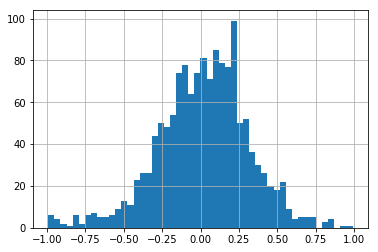

In [98]:
stdtargets = pd.Series(std_target[0])
pred = pd.Series(predictions)
diff = pred.sub(stdtargets)
diff[diff<1][diff>-1].hist(bins=50)

Plotting in terms of raw units

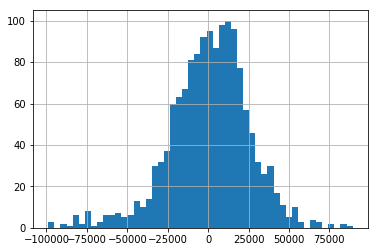

In [104]:
linear_regression_model.fit(std_df, target)
predictions = linear_regression_model.predict(std_df)
pred=pd.Series(predictions)
diff2 = pred.sub(target)
diff2[diff2<100000][diff2>-100000].hist(bins=50)


502389.16542760166


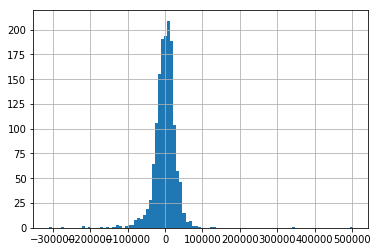

In [107]:
diff2.hist(bins=100)
print(max(diff2))

In [49]:
submission = pd.DataFrame({"Id":test['Id'],"SalePrice":np.exp(test_predictions3)})

In [52]:
submission.to_csv(r"C:\Users\jmoore42\Documents\housing_submission1.csv")

In [53]:
submission

,Id,SalePrice
0,1461,117485.601597
1,1462,160498.307446
2,1463,182878.157932
3,1464,197589.470887
4,1465,183983.069753
5,1466,172989.193482
6,1467,179497.760842
7,1468,160909.310541
8,1469,202059.830762
9,1470,113878.071221
